In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')


import seaborn as sns
import gudhi as gd
from scipy.stats import norm

# Trivariate

### Sampling From a PDF (Metropolis Hastings)

In [2]:
def metropolis_hastings(unnormalized_density, n_samples, proposal_width=1):
    samples = np.zeros((n_samples, 3))
    current_x, current_y, current_z = np.random.randn(3)
    current_density = unnormalized_density(current_x, current_y, current_z)
    
    # Run the Markov chain
    for i in range(n_samples):
        proposed_x = current_x + proposal_width * np.random.randn()
        proposed_y = current_y + proposal_width * np.random.randn()
        proposed_z = current_z + proposal_width * np.random.randn()
        proposed_density = unnormalized_density(proposed_x, proposed_y, proposed_z)
        
        acceptance_ratio = proposed_density / current_density
        
        if np.random.rand() < acceptance_ratio:
            current_x, current_y, current_z = proposed_x, proposed_y, proposed_z
            current_density = proposed_density
        
        samples[i] = [current_x, current_y, current_z]
    
    return samples

# Generate samples
def generate_samples(unnormalized_density, n_samples=10000, burn_in=1000, proposal_width=0.5):
    all_samples = metropolis_hastings(unnormalized_density, n_samples + burn_in, proposal_width)
    samples = all_samples[burn_in:]
    return samples

In [3]:
def gauss1_pdf(x, y, z, h=0):
    return np.exp(-(x**2 - h)**2 - (y**2 - h)**2 - (z**2 - h)**2)

gauss1 = generate_samples(gauss1_pdf, n_samples=1500, burn_in=10000, proposal_width=1)

In [4]:
name = 'gauss1'
X_3D = gauss1

# Grid Search with Early Stopping at Relative Change equal to stability_threshold

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import gudhi.cubical_complex as cubical

def topology_loss(persistence_diagram, lambda1=0.8):
    lifetimes = np.array([d[1][1] - d[1][0] for d in persistence_diagram if d[1][1] < np.inf])
    if len(lifetimes) == 0:
        return tf.constant(np.inf, dtype=tf.float32)
    lifetimes_tf = tf.constant(lifetimes, dtype=tf.float32)
    feature_complexity = tf.reduce_sum(-lifetimes_tf)
    betti_numbers = tf.cast(len(lifetimes), dtype=tf.float32)
    return lambda1 * feature_complexity + (1 - lambda1) * betti_numbers

def compute_cubical_persistence(density_values, grid_shape):
    density_values = density_values / density_values.max()
    function_values = np.array(density_values).reshape(grid_shape)
    cc = cubical.CubicalComplex(top_dimensional_cells=function_values)
    persistence = cc.persistence()
    return persistence

def kde_density_tf(X, x_grid, y_grid, z_grid, bw):
    X_np = X.numpy()
    
    x_grid_np = x_grid.numpy().flatten()
    y_grid_np = y_grid.numpy().flatten()
    z_grid_np = z_grid.numpy().flatten()
    bw = bw.numpy()
    
    grid_points = np.vstack([x_grid_np, y_grid_np, z_grid_np]).T

    kde = gaussian_kde(X_np.T, bw_method=bw)
    densities = kde(grid_points.T)
    return tf.convert_to_tensor(densities, dtype=tf.float32)

def optimize_bandwidth_topology_tf(X, bandwidth_range, grid_shape, stability_threshold=0.1):
    losses = []
    stable_bandwidth = None

    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    z_min, z_max = X[:, 2].min(), X[:, 2].max()
    x_grid, y_grid, z_grid = np.meshgrid(np.linspace(x_min, x_max, grid_shape[0]), 
                                        np.linspace(y_min, y_max, grid_shape[1]),
                                        np.linspace(z_min, z_max, grid_shape[2]))
    
    X_tf = tf.constant(X, dtype=tf.float32)
    x_grid_tf = tf.constant(x_grid, dtype=tf.float32)
    y_grid_tf = tf.constant(y_grid, dtype=tf.float32)
    z_grid_tf = tf.constant(z_grid, dtype=tf.float32)

    for i, bw in enumerate(bandwidth_range):
        bw_tf = tf.constant(bw, dtype=tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(bw_tf)
            density_values = kde_density_tf(X_tf, x_grid_tf, y_grid_tf, z_grid_tf, bw_tf)
            persistence = compute_cubical_persistence(density_values.numpy(), grid_shape)
            loss = topology_loss(persistence)

        losses.append(loss.numpy())

        if i > 1:
            change = abs(losses[-1] - losses[-2]) / abs(losses[-2]) if losses[-2] != 0 else 0
            if change < stability_threshold:
                if stable_bandwidth is None:
                    stable_bandwidth = bw
                    break

    if stable_bandwidth is None:
        stable_bandwidth = bandwidth_range[np.argmin(losses)]

    return stable_bandwidth, losses

In [6]:
h_range = np.linspace(0.05, 1.5, 10)
grid_shape = (10, 10, 10)

In [7]:
best_bandwidth, losses = optimize_bandwidth_topology_tf(X_3D, h_range, grid_shape, stability_threshold=0.01)
kde = gaussian_kde(X_3D.T, bw_method=best_bandwidth)

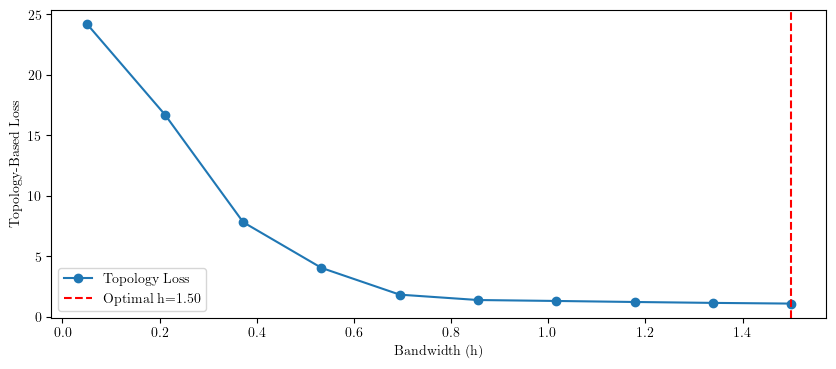

In [8]:
plt.figure(figsize=(10, 4))
plt.plot(h_range[:len(losses)], losses, marker='o', label="Topology Loss")
plt.axvline(best_bandwidth, color='r', linestyle='--', label=f"Optimal h={best_bandwidth:.2f}")
plt.xlabel("Bandwidth (h)")
plt.ylabel("Topology-Based Loss")
plt.legend()
plt.show()

# KDE Comparison (Trivariate)

In [9]:
from scipy.stats import gaussian_kde
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

x_min, x_max = X_3D[:, 0].min(), X_3D[:, 0].max()
y_min, y_max = X_3D[:, 1].min(), X_3D[:, 1].max()
z_min, z_max = X_3D[:, 2].min(), X_3D[:, 2].max()

X, Y, Z = np.meshgrid(np.linspace(x_min, x_max, grid_shape[0]), 
                   np.linspace(y_min, y_max, grid_shape[1]),
                   np.linspace(z_min, z_max, grid_shape[2]))

positions = np.vstack([X.ravel(), Y.ravel(), Z.ravel()])
###############################

pdf1 = gaussian_kde(X_3D.T, bw_method='scott')(positions)

pdf2 = gaussian_kde(X_3D.T, bw_method='silverman')(positions)

grid_search = GridSearchCV(KernelDensity(), {'bandwidth': h_range}, cv=5)
grid_search.fit(X_3D)
pdf3 = gaussian_kde(X_3D.T, bw_method=grid_search.best_params_['bandwidth'])(positions)

###############################

top_pdf1 = gaussian_kde(X_3D.T, bw_method=best_bandwidth)(positions)

In [10]:
def normalize_pdf(pdf_true, x, y, z):

    dx = x[0, 1, 0] - x[0, 0, 0]
    dy = y[1, 0, 0] - y[0, 0, 0]
    dz = z[0, 0, 1] - z[0, 0, 0]

    d_area = dx * dy * dz

    integral_true = np.sum(pdf_true) * d_area
    print(f"Integral of PDF: {integral_true}")
    if integral_true > 0:
        pdf_true_normalized = pdf_true / integral_true
    else:
        pdf_true_normalized = np.zeros_like(pdf_true)

    return pdf_true_normalized

Z_true = globals()[f'gauss1_pdf'](X, Y, Z)
Z_true = normalize_pdf(Z_true, X, Y, Z)

Zs = [pdf1, pdf2, pdf3, top_pdf1]
Zs = [dens.reshape(grid_shape) for dens in Zs]
Zs = [normalize_pdf(dens, X, Y, Z) for dens in Zs]
Zs.append(Z_true)

kdes = Zs

Integral of PDF: 5.947451703528163
Integral of PDF: 0.9912220444454792
Integral of PDF: 0.9921016075940013
Integral of PDF: 0.9923332695739555
Integral of PDF: 0.6272524117773243


In [11]:
def kl_divergence_3d(pdf_true_normalized, kde_normalized, x, y, z):
    dx = x[0, 1, 0] - x[0, 0, 0]
    dy = y[1, 0, 0] - y[0, 0, 0]
    dz = z[0, 0, 1] - z[0, 0, 0]

    d_volume = dx * dy * dz
    kde_normalized = np.where(kde_normalized == 0, 1e-10, kde_normalized)
    kl_div_elements = np.where(pdf_true_normalized > 0,
                               pdf_true_normalized * np.log(pdf_true_normalized / kde_normalized),
                               0)
    kl_div = np.nansum(kl_div_elements) * d_volume
    return kl_div

klds = [kl_divergence_3d(Z_true, kdes[i], X, Y, Z) for i in range(len(kdes))]

print("KLD for each KDE:")
for i, ll in enumerate(klds):
    print(f"KLD {i}: {ll}")

KLD for each KDE:
KLD 0: 0.14459883145422625
KLD 1: 0.15429331816299666
KLD 2: 0.5352034473415467
KLD 3: 0.3647991168968628
KLD 4: 0.0


In [12]:
import ot
def earth_movers_distance_3d(pdf1, pdf2, x, y, z):

    dx = x[0, 1, 0] - x[0, 0, 0]
    dy = y[1, 0, 0] - y[0, 0, 0]
    dz = z[0, 0, 1] - z[0, 0, 0]

    dV = dx * dy * dz

    pdf1 = pdf1.flatten() / (np.sum(pdf1) * dV)
    pdf2 = pdf2.flatten() / (np.sum(pdf2) * dV)
    points = np.vstack([x.ravel(), y.ravel(), z.ravel()]).T

    cost_matrix = ot.dist(points, points)
    wasserstein_dist = ot.emd2(pdf1, pdf2, cost_matrix, numItermax=10000)
    return wasserstein_dist

emds = [earth_movers_distance_3d(Z_true, kdes[i], X, Y, Z) for i in range(len(kdes))]

print("EMD for each 3D KDE:")
for i, ll in enumerate(emds):
    print(f"EMD {i}: {ll}")

c:\Python311\Lib\site-packages\ot\lp\__init__.py:571: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


EMD for each 3D KDE:
EMD 0: 2.4830789310719483
EMD 1: 2.4975042505585656
EMD 2: 3.039176286904454
EMD 3: 5.592752860948762
EMD 4: 1.935404290376408e-17


# Loop to Generate 1500 Simulations

In [ ]:
for i in range(1500):

    gauss1 = generate_samples(gauss1_pdf, n_samples=5000, burn_in=10000, proposal_width=1)

    filename = "gauss1_{}.npy".format(i)
    np.save(filename, gauss1, allow_pickle=True)

In [ ]:
h_range = np.linspace(0.05, 1.5, 100)
grid_shape = (100, 100, 100)

for cat in ['gauss1']:

    for i in range(1500):
        X_3D = np.load(f'{cat}_{i}.npy', allow_pickle=True)
        bw, losses = optimize_bandwidth_topology_tf(X_3D, h_range, grid_shape, stability_threshold=0.01)

        ##############################
        
        x_min, x_max = X_3D[:, 0].min(), X_3D[:, 0].max()
        y_min, y_max = X_3D[:, 1].min(), X_3D[:, 1].max()
        z_min, z_max = X_3D[:, 2].min(), X_3D[:, 2].max()

        X, Y, Z = np.meshgrid(np.linspace(x_min, x_max, grid_shape[0]), 
                        np.linspace(y_min, y_max, grid_shape[1]),
                        np.linspace(z_min, z_max, grid_shape[2]))

        positions = np.vstack([X.ravel(), Y.ravel(), Z.ravel()])

        ###############################

        pdf1 = gaussian_kde(X_3D.T, bw_method='scott')(positions)

        pdf2 = gaussian_kde(X_3D.T, bw_method='silverman')(positions)

        grid_search = GridSearchCV(KernelDensity(), {'bandwidth': h_range}, cv=5)
        grid_search.fit(X_3D)
        pdf3 = gaussian_kde(X_3D.T, bw_method=grid_search.best_params_['bandwidth'])(positions)

        ################################

        top_pdf1 = gaussian_kde(X_3D.T, bw_method=bw)(positions)

        Z_true = globals()[f'{cat}_pdf'](X, Y, Z)
        Z_true = normalize_pdf(Z_true, X, Y, Z)

        Zs = [pdf1, pdf2, pdf3, top_pdf1]
        Zs = [dens.reshape(grid_shape) for dens in Zs]
        Zs = [normalize_pdf(dens, X, Y, Z) for dens in Zs]
        Zs.append(Z_true)

        kdes = Zs

        klds = [kl_divergence_3d(Z_true, kdes[i], X, Y, Z) for i in range(len(kdes))]

        filename = "{}_KLD_{}.npy".format(cat, i)
        np.save(filename, np.array(klds), allow_pickle=True)

Integral of PDF: 5.956160317014261
Integral of PDF: 0.9982441830015153
Integral of PDF: 0.9984921626181414
Integral of PDF: 0.9997661505953984
Integral of PDF: 0.9861698325224678


In [ ]:
for cat in ['gauss1']:

    klds = []
    for i in range(1500):

        filename = "{}_KLD_{}.npy".format(cat, i)
        klds.append(np.load(filename, allow_pickle=True))

    klds = np.array(klds)

    print(np.mean(klds[~np.isinf(klds).any(axis=1)], axis=0))
    print(np.std(klds[~np.isinf(klds).any(axis=1)], axis=0))

[0.0776868  0.08240196 0.2055445  0.08057553 0.        ]
[0. 0. 0. 0. 0.]
